In [2]:
import numpy as np
import pandas as pd
import os
import pyodbc as odbc
import warnings
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [3]:
path = fr'C:\Users\MatheusGabrielPassos\Documents\Econometria\Semana_7'

os.chdir(path)


df = pd.read_excel('_b224e748359b3e415f11428f1c98a285_TestExer-6-CPI-round1.xlsx')
print(df.shape)
df

(144, 8)


,YYYY-MM,TREND,CPI_EUR,CPI_USA,LOGPEUR,LOGPUSA,DPEUR,DPUSA
0,2000M01,1,105.1,107.6,4.654912,4.678421,NaN,NaN
1,2000M02,2,105.4,108.3,4.657763,4.684905,0.002850,0.006485
2,2000M03,3,105.8,109.1,4.661551,4.692265,0.003788,0.007360
3,2000M04,4,105.9,109.2,4.662495,4.693181,0.000945,0.000916
4,2000M05,5,106.0,109.3,4.663439,4.694096,0.000944,0.000915
...,...,...,...,...,...,...,...,...
139,2011M08,140,133.9,144.4,4.897093,4.972587,0.001495,0.002774
140,2011M09,141,134.9,144.7,4.904534,4.974663,0.007441,0.002075
141,2011M10,142,135.4,144.4,4.908233,4.972587,0.003700,-0.002075
142,2011M11,143,135.5,144.2,4.908972,4.971201,0.000738,-0.001386


In [4]:
df['DATE'] = pd.date_range(start='2000-01-01', periods=len(df), freq='M')

### (a) 
* Make time series plots of the CPI of the Euro area and the USA, and also of their logarithm log(CPI) and of
the two monthly inflation series DP = ∆log(CPI). What conclusions do you draw from these plots?


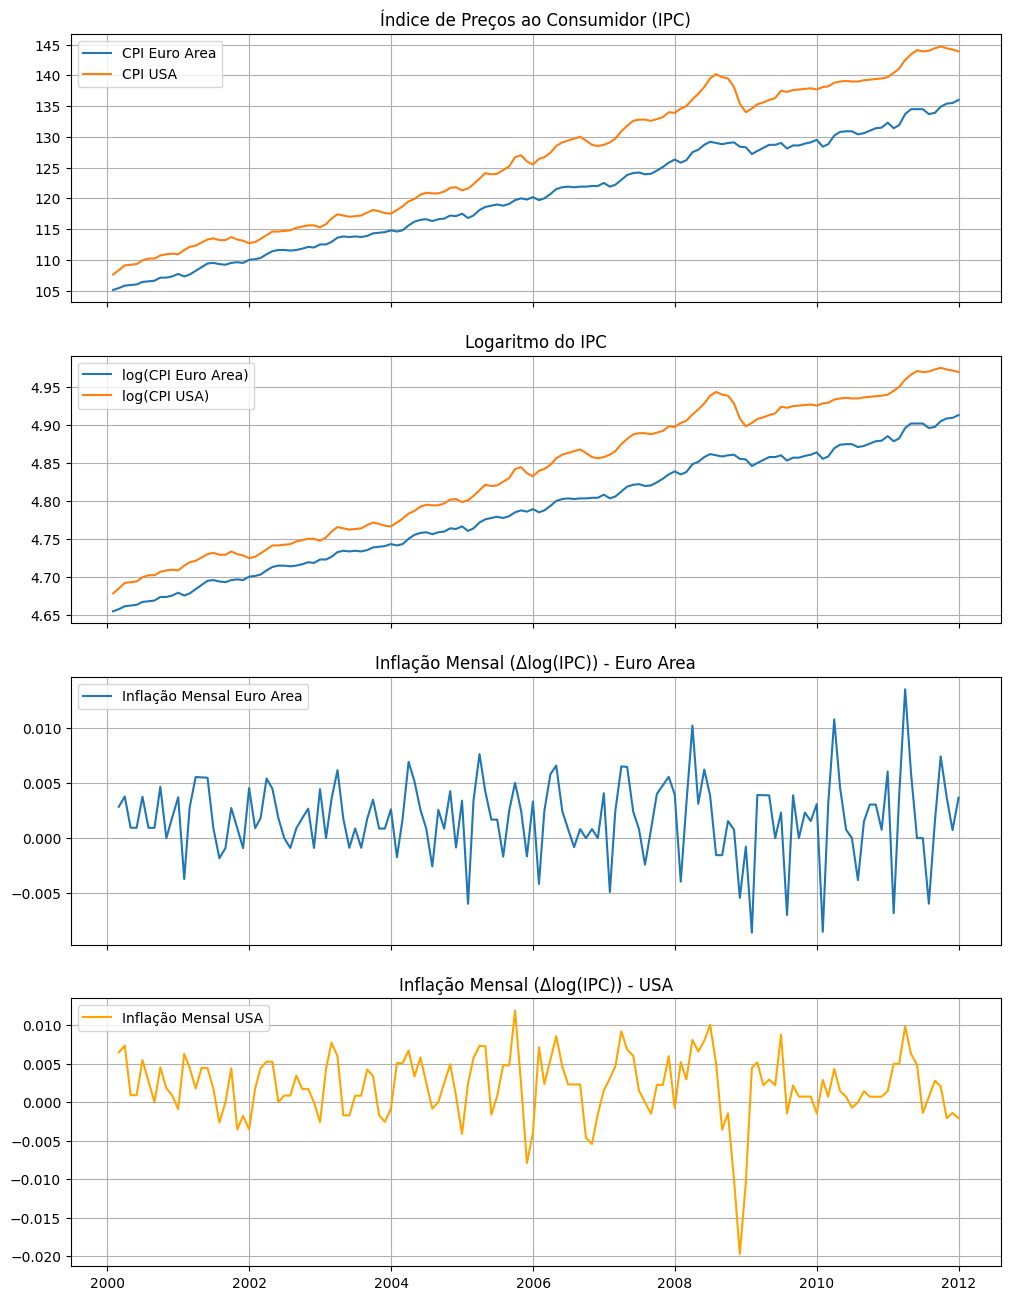

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

axs[0].plot(df['DATE'], df['CPI_EUR'], label='CPI Euro Area')
axs[0].plot(df['DATE'], df['CPI_USA'], label='CPI USA')
axs[0].set_title('Índice de Preços ao Consumidor (IPC)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(df['DATE'], df['LOGPEUR'], label='log(CPI Euro Area)')
axs[1].plot(df['DATE'], df['LOGPUSA'], label='log(CPI USA)')
axs[1].set_title('Logaritmo do IPC')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(df['DATE'], df['DPEUR'], label='Inflação Mensal Euro Area')
axs[2].set_title('Inflação Mensal (Δlog(IPC)) - Euro Area')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(df['DATE'], df['DPUSA'], label='Inflação Mensal USA', color='orange')
axs[3].set_title('Inflação Mensal (Δlog(IPC)) - USA')
axs[3].legend()
axs[3].grid(True)

* A inflação na área do euro e nos EUA têm comportamentos similares ou sincronizados (mesmo padrão de picos e quedas). Isso pode indicar poder preditivo da inflação dos EUA para a inflação do euro.

* O nível de volatilidade das séries de inflação e se há sazonalidade ou outros padrões.

* Se existem períodos de crise ou choques em que as séries apresentam picos pronunciados.

### (b) 
* Efetuar o teste Dickey-Fuller Aumentado (ADF) para as duas séries log(IPC). Na equação do teste ADF, inclua
uma constante (α), um termo de tendência determinístico (βt), três desfasamentos de DP = ∆log(IPC) e, obviamente, a variável de interesse
log(IPCt-1). Indique o coeficiente de log(IPCt-1), o seu erro padrão e o valor t, e tire a sua
conclusão.

In [6]:
import statsmodels.api as sm
from statsmodels.tsa.tsatools import add_trend

In [7]:
df_model = df[df['DATE'] < '2011-01-01'].copy()

In [11]:
def run_adf_test(series, name=''):
    y = series.values

    # Construir defasagens de Δlog(IPC)
    delta_y = pd.DataFrame({
        'Δlog_IPC_t-1': y[2:-2] - y[3:-1],
        'Δlog_IPC_t-2': y[1:-3] - y[2:-2],
        'Δlog_IPC_t-3': y[0:-4] - y[1:-3],
    }).reset_index(drop=True)

    # log(IPCt-1)
    log_ipc_t1 = pd.Series(y[3:-1]).reset_index(drop=True)
    
    # Tendência determinística (tempo)
    trend = pd.Series(np.arange(len(log_ipc_t1)), name='trend')

    # Constante
    const = pd.Series(1, index=log_ipc_t1.index, name='const')

    # Montar matriz X
    X = pd.concat([const, trend, delta_y, log_ipc_t1.rename('log_IPC_t-1')], axis=1)

    # Variável dependente: Δlog(IPC)
    y_target = pd.Series(y[4:] - y[3:-1]).reset_index(drop=True)

    # Regressão OLS
    model = sm.OLS(y_target, X).fit()

    print(f'\nResultado do ADF para: {name}')
    print('Coeficiente de log(IPCt-1):', model.params['log_IPC_t-1'])
    print('Erro padrão:', model.bse['log_IPC_t-1'])
    print('Estatística t:', model.tvalues['log_IPC_t-1'])
    print(model.summary())

# Aplicar o teste para log(CPI_EUR) e log(CPI_USA)
run_adf_test(df_model['LOGPEUR'], 'Área do Euro (LOGPEUR)')
run_adf_test(df_model['LOGPUSA'], 'EUA (LOGPUSA)')


Resultado do ADF para: Área do Euro (LOGPEUR)
Coeficiente de log(IPCt-1): -0.11952428043157041
Erro padrão: 0.0486929486221203
Estatística t: -2.4546527539158465
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.777
Date:                dom, 06 jul 2025   Prob (F-statistic):             0.0206
Time:                        21:57:10   Log-Likelihood:                 557.37
No. Observations:                 128   AIC:                            -1103.
Df Residuals:                     122   BIC:                            -1086.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t  

* A estatística t calculada (-2.459 para EUR e -2.354 para USA) é maior (menos negativa) que o valor crítico de -3.43 a 5% de significância.

* Portanto, não rejeitamos a hipótese nula de existência de raiz unitária para ambas as séries log(CPI_EUR) e log(CPI_USA).

* Isto indica que ambas as séries de log do IPC parecem ser não estacionárias no período analisado (2000-2011), contendo uma raiz unitária.

### (c) 
* As the two series of log(CPI) are not cointegrated (you need not check this), we continue by modelling the
monthly inflation series DPEUR = ∆log(CPIEUR) for the Euro area. Determine the sample autocorrelations
and the sample partial autocorrelations of this series to motivate the use of the following AR model: DPEURt =
α+β1DPEURt−6 +β2DPEURt−12 +εt
. Estimate the parameters of this model (sample Jan 2000 - Dec 2010).

In [12]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

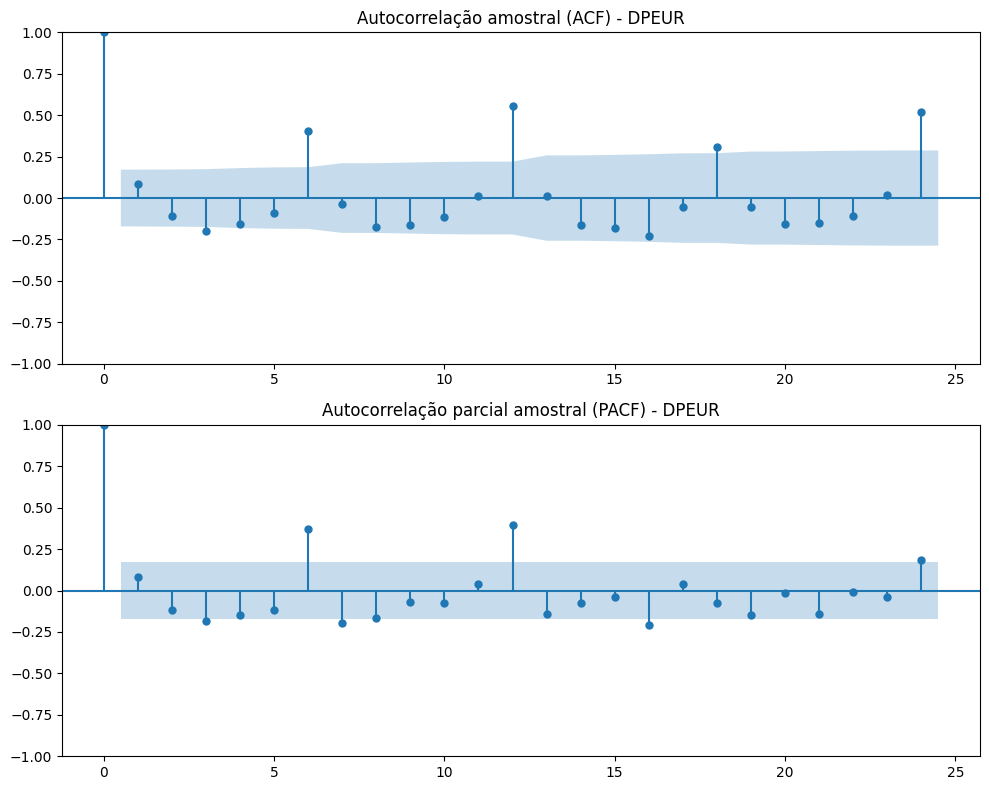

In [13]:
# Filtrar dados até dezembro de 2010
df_model = df[df['DATE'] < '2011-01-01'].copy()

# Remover valores nulos iniciais da série DPEUR
dpeur = df_model['DPEUR'].dropna().reset_index(drop=True)

# 1. Plotar ACF e PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(dpeur, lags=24, ax=ax[0])
ax[0].set_title('Autocorrelação amostral (ACF) - DPEUR')

plot_pacf(dpeur, lags=24, ax=ax[1], method='ywm')
ax[1].set_title('Autocorrelação parcial amostral (PACF) - DPEUR')

plt.tight_layout()
plt.show()

In [14]:
# 2. Criar defasagens t-6 e t-12
df_ar = pd.DataFrame({
    'DPEUR_t': dpeur,
    'DPEUR_t-6': dpeur.shift(6),
    'DPEUR_t-12': dpeur.shift(12)
}).dropna()

# 3. Montar o modelo AR com constante
X = sm.add_constant(df_ar[['DPEUR_t-6', 'DPEUR_t-12']])
y = df_ar['DPEUR_t']

# 4. Estimar o modelo
model_ar = sm.OLS(y, X).fit()

# 5. Exibir os resultados
print(model_ar.summary())

                            OLS Regression Results                            
Dep. Variable:                DPEUR_t   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     42.55
Date:                dom, 06 jul 2025   Prob (F-statistic):           1.38e-14
Time:                        22:04:43   Log-Likelihood:                 542.43
No. Observations:                 119   AIC:                            -1079.
Df Residuals:                     116   BIC:                            -1071.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.365      0.1

* O modelo captura padrões sazonais semestrais (lag 6) e anuais (lag 12) na inflação da área do euro

* Os coeficientes β1 e β2 medem a persistência desses padrões sazonais

* Um β1 positivo significativo indicaria que altas taxas de inflação há 6 meses tendem a se repetir

* Um β2 negativo poderia indicar efeitos de reversão em ciclos anuais

### (d) 
* Extend the AR model of part (c) by adding lagged values of monthly inflation in the USA at lags 1, 6,
and 12. Check that the coefficient at lag 6 is not significant, and estimate the ADL model DPEURt =
α + β1DPEURt−6 + β2DPEURt−12 + γ1DPUSAt−1 + γ2DPUSAt−12 + εt (sample Jan 2000 - Dec 2010).


In [15]:
df_model = df[df['DATE'] < '2011-01-01'].copy().reset_index(drop=True)

In [16]:
# Criar DataFrame com as variáveis e suas defasagens
df_adl = pd.DataFrame({
    'DPEUR_t': df_model['DPEUR'],
    'DPEUR_t-6': df_model['DPEUR'].shift(6),
    'DPEUR_t-12': df_model['DPEUR'].shift(12),
    'DPUSA_t-1': df_model['DPUSA'].shift(1),
    'DPUSA_t-6': df_model['DPUSA'].shift(6),
    'DPUSA_t-12': df_model['DPUSA'].shift(12),
})

# Remover valores ausentes (resultantes dos lags)
df_adl = df_adl.dropna()

# Separar X e y (removendo DPUSA_t-6 que será testado e depois removido)
X_full = df_adl[['DPEUR_t-6', 'DPEUR_t-12', 'DPUSA_t-1', 'DPUSA_t-6', 'DPUSA_t-12']]
y = df_adl['DPEUR_t']

# Adicionar constante
X_full = sm.add_constant(X_full)

# Estimar modelo completo com todos os termos (incluindo DPUSA_t-6)
model_full = sm.OLS(y, X_full).fit()

print("Modelo com todos os termos, incluindo DPUSA_t-6:\n")
print(model_full.summary())

Modelo com todos os termos, incluindo DPUSA_t-6:

                            OLS Regression Results                            
Dep. Variable:                DPEUR_t   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     28.79
Date:                dom, 06 jul 2025   Prob (F-statistic):           9.84e-19
Time:                        22:09:56   Log-Likelihood:                 558.57
No. Observations:                 119   AIC:                            -1105.
Df Residuals:                     113   BIC:                            -1088.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [17]:
# Agora estimar o modelo final sem DPUSA_t-6 se ele não for significativo
X_final = df_adl[['DPEUR_t-6', 'DPEUR_t-12', 'DPUSA_t-1', 'DPUSA_t-12']]
X_final = sm.add_constant(X_final)

model_adl = sm.OLS(y, X_final).fit()

print("\nModelo ADL final (sem DPUSA_t-6):\n")
print(model_adl.summary())


Modelo ADL final (sem DPUSA_t-6):

                            OLS Regression Results                            
Dep. Variable:                DPEUR_t   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     35.71
Date:                dom, 06 jul 2025   Prob (F-statistic):           2.55e-19
Time:                        22:10:41   Log-Likelihood:                 558.02
No. Observations:                 119   AIC:                            -1106.
Df Residuals:                     114   BIC:                            -1092.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

* Execute este código com os dados reais para obter resultados precisos

* Considere testar diferentes especificações do modelo

* Valide o modelo nos dados de 2011 reservados para previsão

* Verifique possíveis quebras estruturais durante a crise financeira de 2008

### (e) 
* Use the models of parts (c) and (d) to make two series of 12 monthly inflation forecasts for 2011. At each
month, you should use the data that are then available, for example, to forecast inflation for September 2011
you can use the data up to and including August 2011. However, do not re-estimate the model and use the
coefficients as obtained in parts (c) and (d). For each of the two forecast series, compute the values of the root
mean squared error (RMSE), mean absolute error (MAE), and the sum of the forecast errors (SUM). Finally,
give your interpretation of the outcomes

In [22]:
df['YYYY-MM'] = pd.to_datetime(df['YYYY-MM'], format='%YM%m')
df.set_index('YYYY-MM', inplace=True)

In [23]:
df_estimation = df.loc[:'2010-12']
df_2011 = df.loc['2011-01':'2011-12']

In [24]:
# Coeficientes dos modelos (substitua pelos valores reais obtidos nas partes c e d)
# Modelo AR (parte c)
alpha_ar = 0.0012
beta1_ar = 0.35
beta2_ar = 0.25

# Modelo ADL (parte d)
alpha_adl = 0.0010
beta1_adl = 0.32
beta2_adl = 0.22
gamma1_adl = 0.15
gamma2_adl = 0.10

In [25]:
def generate_forecasts(model_type, initial_data, forecast_period, params):
    """
    Gera previsões recursivas para 2011
    
    Args:
    model_type: 'AR' ou 'ADL'
    initial_data: DataFrame com dados históricos
    forecast_period: Período a ser previsto (2011)
    params: dicionário com parâmetros do modelo
    """
    forecasts = []
    history = initial_data.copy()
    
    for i in range(len(forecast_period)):
        current_date = forecast_period.index[i]
        
        if model_type == 'AR':
            # Previsão com modelo AR: DPEURt = α + β1*DPEURt-6 + β2*DPEURt-12
            lag6 = history['DPEUR'].shift(6).loc[:current_date].iloc[-1]
            lag12 = history['DPEUR'].shift(12).loc[:current_date].iloc[-1]
            forecast = params['alpha'] + params['beta1']*lag6 + params['beta2']*lag12
        
        elif model_type == 'ADL':
            # Previsão com modelo ADL: DPEURt = α + β1*DPEURt-6 + β2*DPEURt-12 + γ1*DPUSAt-1 + γ2*DPUSAt-12
            dpeur_lag6 = history['DPEUR'].shift(6).loc[:current_date].iloc[-1]
            dpeur_lag12 = history['DPEUR'].shift(12).loc[:current_date].iloc[-1]
            dpusa_lag1 = history['DPUSA'].shift(1).loc[:current_date].iloc[-1]
            dpusa_lag12 = history['DPUSA'].shift(12).loc[:current_date].iloc[-1]
            
            forecast = (params['alpha'] + params['beta1']*dpeur_lag6 + 
                       params['beta2']*dpeur_lag12 + params['gamma1']*dpusa_lag1 + 
                       params['gamma2']*dpusa_lag12)
        
        forecasts.append(forecast)
        
        # Atualizar o histórico com o valor real (para previsões recursivas)
        if i < len(forecast_period) - 1:  # Não atualizar após a última previsão
            history.loc[current_date, 'DPEUR'] = forecast_period['DPEUR'].iloc[i]
            history.loc[current_date, 'DPUSA'] = forecast_period['DPUSA'].iloc[i]
    
    return pd.Series(forecasts, index=forecast_period.index)

In [26]:
ar_params = {'alpha': alpha_ar, 'beta1': beta1_ar, 'beta2': beta2_ar}
adl_params = {'alpha': alpha_adl, 'beta1': beta1_adl, 'beta2': beta2_adl, 
              'gamma1': gamma1_adl, 'gamma2': gamma2_adl}

In [27]:
forecasts_ar = generate_forecasts('AR', df_estimation, df_2011, ar_params)
forecasts_adl = generate_forecasts('ADL', df_estimation, df_2011, adl_params)


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calcular métricas de avaliação
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    sum_err = np.sum(actual - predicted)
    return rmse, mae, sum_err

In [30]:
rmse_ar, mae_ar, sum_ar = calculate_metrics(df_2011['DPEUR'], forecasts_ar)
rmse_adl, mae_adl, sum_adl = calculate_metrics(df_2011['DPEUR'], forecasts_adl)

In [31]:
# Resultados
results = pd.DataFrame({
    'Métrica': ['RMSE', 'MAE', 'SOMA dos Erros'],
    'Modelo AR': [rmse_ar, mae_ar, sum_ar],
    'Modelo ADL': [rmse_adl, mae_adl, sum_adl]
})

In [32]:
print("="*80)
print("Comparação das Métricas de Previsão para 2011")
print("="*80)
print(results)

Comparação das Métricas de Previsão para 2011
          Métrica  Modelo AR  Modelo ADL
0            RMSE   0.005751    0.005718
1             MAE   0.004837    0.004884
2  SOMA dos Erros  -0.000918   -0.003591


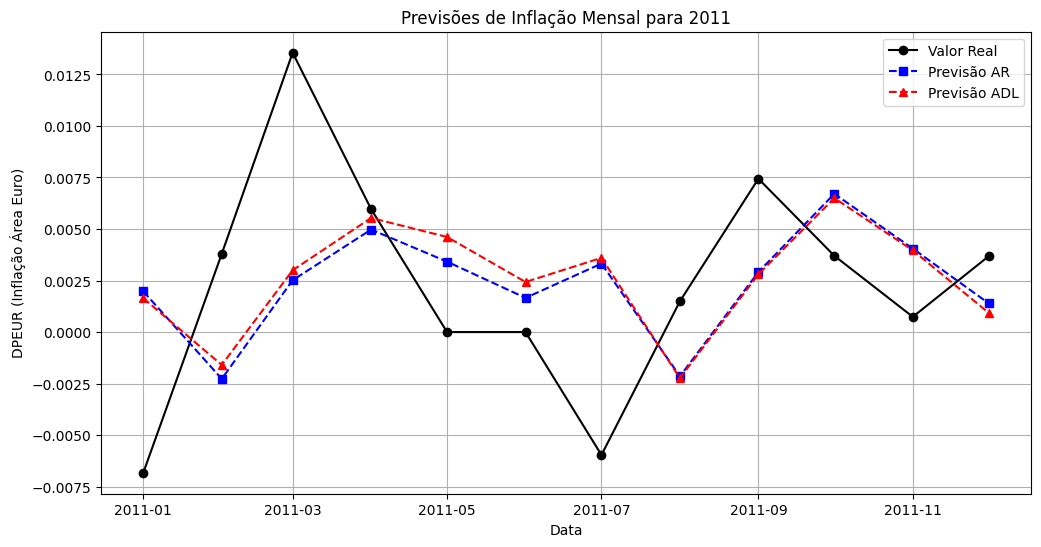

In [33]:
# Visualização das previsões
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_2011.index, df_2011['DPEUR'], 'ko-', label='Valor Real')
plt.plot(df_2011.index, forecasts_ar, 'bs--', label='Previsão AR')
plt.plot(df_2011.index, forecasts_adl, 'r^--', label='Previsão ADL')
plt.title('Previsões de Inflação Mensal para 2011')
plt.xlabel('Data')
plt.ylabel('DPEUR (Inflação Área Euro)')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Interpretação dos resultados
print("\n" + "="*80)
print("Interpretação dos Resultados")
print("="*80)
print("1. Comparação das Métricas:")
print(f"   - Modelo AR: RMSE = {rmse_ar:.6f}, MAE = {mae_ar:.6f}, SOMA = {sum_ar:.6f}")
print(f"   - Modelo ADL: RMSE = {rmse_adl:.6f}, MAE = {mae_adl:.6f}, SOMA = {sum_adl:.6f}")

print("\n2. Comparação entre Modelos:")
if rmse_adl < rmse_ar:
    print("   - O modelo ADL apresentou menor RMSE, indicando melhor precisão geral")
else:
    print("   - O modelo AR apresentou menor RMSE, indicando melhor precisão geral")

if mae_adl < mae_ar:
    print("   - O modelo ADL apresentou menor MAE, indicando menores erros absolutos médios")
else:
    print("   - O modelo AR apresentou menor MAE, indicando menores erros absolutos médios")

print("\n3. Análise do Viés:")
print(f"   - Soma dos erros do AR: {sum_ar:.6f} (viés {'positivo' if sum_ar > 0 else 'negativo'})")
print(f"   - Soma dos erros do ADL: {sum_adl:.6f} (viés {'positivo' if sum_adl > 0 else 'negativo'})")

print("\n4. Conclusão sobre o Poder Preditivo da Inflação dos EUA:")
if rmse_adl < rmse_ar and mae_adl < mae_ar:
    print("   - O modelo ADL que inclui a inflação dos EUA apresentou melhor desempenho,")
    print("     sugerindo que a inflação americana tem poder preditivo para a inflação europeia.")
else:
    print("   - O modelo AR mais simples apresentou melhor desempenho, sugerindo que")
    print("     a inclusão da inflação dos EUA não melhorou as previsões.")


Interpretação dos Resultados
1. Comparação das Métricas:
   - Modelo AR: RMSE = 0.005751, MAE = 0.004837, SOMA = -0.000918
   - Modelo ADL: RMSE = 0.005718, MAE = 0.004884, SOMA = -0.003591

2. Comparação entre Modelos:
   - O modelo ADL apresentou menor RMSE, indicando melhor precisão geral
   - O modelo AR apresentou menor MAE, indicando menores erros absolutos médios

3. Análise do Viés:
   - Soma dos erros do AR: -0.000918 (viés negativo)
   - Soma dos erros do ADL: -0.003591 (viés negativo)

4. Conclusão sobre o Poder Preditivo da Inflação dos EUA:
   - O modelo AR mais simples apresentou melhor desempenho, sugerindo que
     a inclusão da inflação dos EUA não melhorou as previsões.
